<a href="https://colab.research.google.com/github/GregSym/Numberphile_Follow_Alongs/blob/spoon/NumberphileFollowAlongs_StonesOnAnInfiniteChessboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stones on an Infinite Chessboard
https://www.youtube.com/watch?v=m4Uth-EaTZ8

A game in which a set of starting stones of value one are placed on a theoretically infinite grid in order to generate the largest possible sequence of natural numbers by evaluating the sum of a cell in the aforementioned grid's cells.

I suppose part of the challenge here is visualising that so it's not as confusing as I made it sound. The YT video is much easier to follow.

In [ ]:
from __future__ import annotations
import collections
import numpy as np

## Principle setup for running the game

In [ ]:
board: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)

In [ ]:
def setup_init_state(board: collections.defaultdict[int], init_stones=2):
  if init_stones==2:
    board[(0, 0)] = 1
    board[(2, 2)] = 1

adjacency = ((-1, -1), (0, -1), (1, -1), (-1, 0), (-1, 1), (1, 0), (0, 1), (1, 1))
assert len(set(adjacency)) == 8  # check for 8 unique elements because i screw these up a lot

def play_game(board: collections.defaultdict[tuple[int, int], int]):
  max_x = max(k[0] for k in board)
  max_y = max(k[1] for k in board)
  for x in range(max_x+1):
    for y in range(max_y+1):
      adj_sum = sum(board[(x+dx, y+dy)] for (dx,dy) in adjacency)
      if adj_sum not in board.values() and adj_sum == max(board.values()) + 1 and board[(x, y)] == 0:
        board[(x, y)] = adj_sum

def board_to_data(board: collections.defaultdict[tuple[int, int], int]) -> list[list[int]]:
  if any((x<0 or y<0) for x, y in board):
    diagonal_shift = collections.defaultdict(lambda: 0)
    diagonal_shift.update({(x-min(x for x,y in board), y-min(y for x,y in board)): value for (x,y), value in board.items()})
    board = diagonal_shift
  max_x = max(x for (x,y) in board)
  max_y = max(y for (x,y) in board)
  data = np.zeros((max_x+1+1, max_y+1+1))
  for (x, y), value in board.items():
    data[y, x] = value
  return data

In [ ]:
setup_init_state(board=board)
play_game(board=board)
print(board_to_data(board=board))
play_game(board=board)
print(board_to_data(board=board))

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 3. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 3. 1. 0. 0. 0.]
 [0. 0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


## Packaging some of this functionality

In [ ]:
from typing import Counter

class NumbersAndStones:
  """ Useful namespace for containing the game and its board """
  def __init__(self, initial_state: int = 2):
    self.initial_state = initial_state
    self.paths = [set()]
    self.blacklist: Counter[Stone] = collections.Counter()
    self.recurrances: Counter[str] = collections.Counter()
    self.setup()

  def setup(self):
    self.board: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)
    self.last_state: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)
    setup_init_state(board=self.board, init_stones=self.initial_state)
    self.last_state.update(self.board)
    self.sequence: set[int] = set()
  
  def play_game(self):
    self.last_state = collections.defaultdict(lambda: 0)
    self.last_state.update(self.board)
    valid_x = [x for (x,y) in self.board if self.board[x,y] > 0]
    valid_y = [y for (x,y) in self.board if self.board[x,y] > 0]
    min_x = min(valid_x)
    min_y = min(valid_y)
    max_x = max(valid_x)
    max_y = max(valid_y)
    for x in range(min_x-1, max_x+1):
      for y in range(min_y-1, max_y+1):
        adj_sum = sum(self.board[(x+dx, y+dy)] for (dx,dy) in adjacency)
        if (
            adj_sum not in self.board.values()
            and adj_sum == max(self.board.values()) + 1 
            and self.board[(x, y)] == 0
            and ((x,y), adj_sum) not in self.blacklist
            ):
          print(adj_sum)
          self.board[(x, y)] = adj_sum
          continue
  
  def evaluate_growth(self) -> bool:
    """ 
    return whether or not growth stagnated (mathematically this <i>must</i> happen)
    irrespective of init state
    True: growth
    False: stagnated
    """
    return not self.sequence == set({*self.last_state.values()})
  
  def play_sequence(self):
    self.sequence = set()
    self.play_game()
    while self.evaluate_growth():
      self.play_game()
      self.sequence.update({*self.board.values()})
    if max(self.board.values()) > 3:
      failed_placement, = [(indeces, v) for indeces, v in self.board.items() if v==max(self.board.values())]
    else:
      failed_placement = Stone((0,0), 0)
    self.blacklist[Stone(*failed_placement)] += 1
    for i in range(self.blacklist[Stone(*failed_placement)]):
      new_board = {k: v if v < max(*self.board.values()) or v==1 else 0 for k,v in self.board.items()}
      # more_badlist = [Stone(indeces, v) for indeces, v in self.board.items() if v not in new_board.values() and v>3]
      # self.blacklist.update({*more_badlist})
      self.board.update(new_board)
    print(self.blacklist)
    if max(self.sequence) < 9:
      self.recurrances['re'] += 1
      # print(self.recurrances)
      self.play_sequence()
    self.paths[0].update({i for i,v in self.board.items() if v>1})
  
  @property
  def ndarray(self):
    return board_to_data(board=self.board)

### Abstracting the 'Stone'
We're going to want to keep track of some of these, and an easily identifiable object is probably called for

(While making Stone I figured I'd just make a tree too, because those are always so fun!)

In [ ]:
from typing import Callable
import functools

@functools.lru_cache(maxsize=1024)
def neighbour_gen(x,y) -> list[tuple[int, int]]:
  _neighbour_gen: Callable[[int, int], list[tuple[int, int]]] = lambda x, y: [(x+dx, y+dy) for (dx,dy) in adjacency]
  return _neighbour_gen(x,y)

@functools.lru_cache(maxsize=1024)
def cached_sum(*_arraylike) -> int:
  return sum(*_arraylike)

In [ ]:
from typing import NamedTuple, Generator, Union

class Stone(NamedTuple):
  index: tuple[int, int]
  value: int

  def __eq__(self, other) -> bool:
    """ ensure nested equality of the tuple """
    if isinstance(other, Stone):
      return (other.index == self.index) and (other.value == self.value)
    if isinstance(other, tuple):
      return (other[0] == self.index) and (other[1] == self.value)
    return False

class Node(NamedTuple):
  """ repr for a point in the PossibilityTree """
  stone: Stone
  parent: Union[Node, None]
  children: list[Node]

class PossibilityTree(NamedTuple):
  root: Node
  init_board: collections.defaultdict[tuple[int, int], int]

  def _get_parent_chain(self, node: Node) -> Generator[Node, None, None]:
    yield node
    if node == self.root:
      return
    for upstream in self._get_parent_chain(node=node.parent):  # this will fail after 999
      yield upstream

  @property
  def nodes(self) -> Generator[Node, None, None]:
    def ret_children(node: Node) -> Generator[Node, None, None]:
      yield node
      for node in node.children:
        for nested in ret_children(node):
          yield nested
    for nested in ret_children(self.root):
      yield nested

  def add_node(self, node: Node):
    for n in self.nodes:
      if n.stone == node.parent:
        n.children.append(node)
  
  @property
  def layers(self) -> collections.defaultdict[int, list[Node]]:
    """ () -> dict[number of layer, all Stones in a layer of the tree] """
    _layers: collections.defaultdict[int, list[Node]] = collections.defaultdict(lambda: list())
    for node in self.nodes:
      _layers[node.stone.value].append(node)
    return _layers
  
  @property
  def max_layer(self) -> set[Node]:
    _layers = self.layers  # don't run twice / pre-calc here
    return _layers[max(_layers)]
  
  def board_from_node(self, node: Node, low_memory=False) -> collections.defaultdict[tuple[int, int], int]:
    _board = collections.defaultdict(lambda: 0)
    _board.update(self.init_board)
    _board.update({(x,y): value for ((x,y), value), parent, children in self.sequence_at_node(node=node)})
    return _board

  @property
  def longest_board(self) -> collections.defaultdict[tuple[int, int], int]:
    return self.board_from_node(node=self.longest_node)

  def new_layer(self):
    """ compute and append a new layer to the highest layer """
    new_layer_value = max(self.layers) + 1
    print(new_layer_value)
    for node in self.max_layer:
      current_board = self.board_from_node(node)
      for (x, y), num in current_board.items():
        for nx, ny in neighbour_gen(x,y):
          if current_board.get((nx, ny), 0) != 0:
            continue
          adj_sum = cached_sum(current_board.get((nx+dx, ny+dy), 0) for (dx,dy) in adjacency)
          if adj_sum == new_layer_value:
            node.children.append(
                Node(stone=Stone(index=(nx,ny), value=new_layer_value), parent=node, children=[]))

  @property
  def longest_node(self) -> Node:
    """ returns an arbitrary node in the maximum number layer """
    return self.max_layer.pop()
  
  def sequence_at_node(self, node: Node) -> Generator[Node, None, None]:
    for _node in self._get_parent_chain(node):
      yield _node
  
  @property
  def longest_sequence(self) -> Generator[Node, None, None]:
    for node in self.sequence_at_node(self.longest_node):
      yield node

  @property
  def branch_points(self) -> Generator[Node, None, None]:
    for node in self.nodes:
      if len(node.children) > 1:
        yield node

## Abstract class for visualisation integration

In [ ]:
import sys
if float(f"{sys.version_info[0]}.{sys.version_info[1]}") < 3.8:
  from typing_extensions import Protocol  # < 3.8 Protocol lives in a different package
else:
  from typing import Protocol

class _GrowableNumberPattern(Protocol):
  @property
  def board(self) -> dict[tuple[int,int], int]:...
  @property
  def sequence(self) -> set[int]:...
  @property
  def ndarray(self):...

In [ ]:
from abc import ABC, abstractmethod

class NumbersAndStonesABC(ABC):
  """ Parent ABC that cheats by containing some useful visualisation stuff that
      could clutter up the solver
  """
  @abstractmethod
  def play_sequence(self):
    """ Play out all possible sequences for an initial state defined before calling """
  
  @property
  def ndarray(self):
    return board_to_data(board=self.board)

In [ ]:
class NumbersAndStones(NumbersAndStonesABC):
  """ Useful namespace for containing the game and its board """
  def __init__(self, initial_state: int = 2):
    self.initial_state = initial_state
    self.board: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)
    setup_init_state(board=self.board, init_stones=self.initial_state)
    root = Stone(*[stone for stone in self.board.items()][0])
    self.sequence = []
    self.tree: PossibilityTree = PossibilityTree(
        Node(stone=root, parent=None, children=[]), self.board)
  
  def play_sequence(self):
    while True:
      # store current layer
      layer_value = self.tree.longest_node.stone.value
      # get a new layer
      self.tree.new_layer()
      # find new layer
      new_value = self.tree.longest_node.stone.value
      # test for growth
      if new_value == layer_value:
        self.board = self.tree.longest_board
        break
    self.sequence = [*self.board.values()]
    print(self.board)

In [ ]:
from typing import Any

class ComputedGame(NamedTuple):
  """
  Contains only the data of a game,
  fulfills interface/Protocol but doesn't inherit from ABC version.
  Primarily for caching the game, may have mocking applications
  """
  initial_state: int
  board: collections.defaultdict[tuple[int,int], int]
  tree: PossibilityTree
  sequence: list[int]
  ndarray: Any  # npt.NDArray[np.int64] (note: numpy.typing=npt, numpy=np)

  def play_sequence(self):...

@functools.lru_cache(maxsize=None)
def cache_tree_computation() -> ComputedGame:
  print("Cold run...")
  game = NumbersAndStones()
  game.play_sequence()
  print(game.ndarray)
  print(game.sequence)
  return ComputedGame(initial_state=game.initial_state, 
                      board=game.board, 
                      tree=game.tree,
                      sequence=game.sequence, 
                      ndarray=game.ndarray)

game = cache_tree_computation()
print(game.ndarray)
print(game.sequence)

Cold run...
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
defaultdict(<function PossibilityTree.board_from_node.<locals>.<lambda> at 0x7fe10e1a9440>, {(0, 0): 1, (2, 2): 1, (-1, -1): 16, (0, -1): 15, (1, -1): 14, (2, 0): 13, (1, 4): 12, (3, 1): 11, (3, 2): 10, (3, 4): 9, (1, 3): 8, (-1, 1): 7, (0, 1): 6, (3, 3): 5, (2, 3): 4, (1, 2): 3, (1, 1): 2})
[[16. 15. 14.  0.  0.  0.  0.]
 [ 0.  1.  0. 13.  0.  0.  0.]
 [ 7.  6.  2.  0. 11.  0.  0.]
 [ 0.  0.  3.  1. 10.  0.  0.]
 [ 0.  0.  8.  4.  5.  0.  0.]
 [ 0.  0. 12.  0.  9.  0.  0.]]
[1, 1, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
[[16. 15. 14.  0.  0.  0.  0.]
 [ 0.  1.  0. 13.  0.  0.  0.]
 [ 7.  6.  2.  0. 11.  0.  0.]
 [ 0.  0.  3.  1. 10.  0.  0.]
 [ 0.  0.  8.  4.  5.  0.  0.]
 [ 0.  0. 12.  0.  9.  0.  0.]]
[1, 1, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]


## Should probably test some fundamentals

In [ ]:
def test_natural_numbers(pattern: _GrowableNumberPattern):
  for el, next_el in zip(sorted(set(pattern.sequence)), list(sorted(set(pattern.sequence)))[1:]):
    assert el + 1 == next_el, f"sequence break @ {el} - {next_el}"

def test_largest_eq_sum(pattern: _GrowableNumberPattern):
  ((x,y), max_v), = [((x,y),max_v) for (x,y),max_v in pattern.board.items() if max_v==max(pattern.board.values())]
  assert sum(pattern.board[(x+dx, y+dy)] for (dx,dy) in adjacency) == max_v, f"{sum(pattern.board[(x+dx, y+dy)] for (dx,dy) in adjacency)} not equal to {max_v},\n board:\n {pattern.ndarray}"
  if max_v > 2:
    pattern.board.pop((x,y))
    test_largest_eq_sum(pattern=pattern)
  return
      
game = cache_tree_computation()
game.play_sequence()
test_natural_numbers(game)
test_largest_eq_sum(game)

## But can it look more interesting than an NDArray?

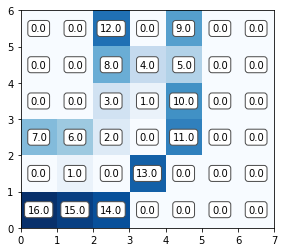

In [ ]:
import matplotlib.pyplot as plt
import sys

class _VisualiserInterfaceCheckerboardCounting(Protocol):
  """ Interface for visualisation in this notebook """
  def __call__(self, pattern: _GrowableNumberPattern, verbose: bool) -> None:
      ...

def visualise_checkerboard_counting(pattern: _GrowableNumberPattern, verbose: bool = False):
  """ (pattern) -> visualisation of checkerboard counting game """
  # src: https://stackoverflow.com/questions/36668160/graphing-a-colored-grid-in-python
  # thanccs == asker: fosho, answerer: Suever
  # Just some example data (random)
  data = pattern.ndarray  # change this line to control colour map

  rows,cols = data.shape
  plt.imshow(data[::-1,::], interpolation='nearest', 
                  extent=[0, 0+cols, 0, 0+rows],  # offset should be zero
                  cmap='Blues')  # controls colour scheme
  # write stone value to the heat map
  for (y,x), stone in np.ndenumerate(data):
    plt.text(x+.5, y+.5, str(stone), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
  # plt.axes()
  plt.axis('scaled')
  plt.show()

# run it
game = cache_tree_computation()
game.play_sequence()
visualise_checkerboard_counting(pattern=game)